In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
#dataset:https://github.com/CSSEGISandData/COVID-19
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = death_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

full_table = confirmed_table.merge(death_table).merge(recovered_table)

full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,2020-01-22,0,0,0
1,,Albania,2020-01-22,0,0,0
2,,Algeria,2020-01-22,0,0,0
3,,Andorra,2020-01-22,0,0,0
4,,Angola,2020-01-22,0,0,0
...,...,...,...,...,...,...
18520,,Malawi,2020-04-05,4,0,0
18521,Falkland Islands (Islas Malvinas),United Kingdom,2020-04-05,2,0,0
18522,Saint Pierre and Miquelon,France,2020-04-05,1,0,0
18523,,South Sudan,2020-04-05,1,0,0


In [3]:
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered,Active
0,,Afghanistan,2020-01-22,0,0,0,0
1,,Albania,2020-01-22,0,0,0,0
2,,Algeria,2020-01-22,0,0,0,0
3,,Andorra,2020-01-22,0,0,0,0
4,,Angola,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...
18520,,Malawi,2020-04-05,4,0,0,4
18521,Falkland Islands (Islas Malvinas),United Kingdom,2020-04-05,2,0,0,2
18522,Saint Pierre and Miquelon,France,2020-04-05,1,0,0,1
18523,,South Sudan,2020-04-05,1,0,0,1


In [4]:
def get_time_series(country):
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed', 'Deaths', 'Recovered', 'Active'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]


def get_time_series_province(province):
    df = full_table[(full_table['Province/State'] == province)]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]

In [5]:
country = 'India'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail(10)

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-03-27,887,20,73,794
2020-03-28,987,24,84,879
2020-03-29,1024,27,95,902
2020-03-30,1251,32,102,1117
2020-03-31,1397,35,123,1239
2020-04-01,1998,58,148,1792
2020-04-02,2543,72,191,2280
2020-04-03,2567,72,192,2303
2020-04-04,3082,86,229,2767


In [6]:
import math
def model_with_lag(N, a, alpha, lag, t):
    lag = min(max(lag, -100), 100) # lag must be less than +/- 100 days 
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [7]:
model_index = 0

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
#         r += (math.log(1 + model(N, a, alpha, t)) - math.log(1 + df.iloc[t, 0])) ** 2 
#         r += (model_with_lag(N, a, alpha, lag, t) - df.iloc[t, 0]) ** 2
#         print(model(N, a, alpha, t), df.iloc[t, 0])
    return math.sqrt(r) 

In [8]:
import numpy as np
from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x

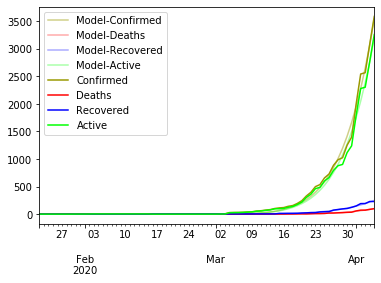

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

model_sim['Model-Active'] = model_sim['Model-Confirmed'] - model_sim['Model-Deaths'] - model_sim['Model-Recovered']
model_sim.loc[model_sim['Model-Active']<0,'Model-Active'] = 0
plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([model_sim, df], axis=1).plot(color = plot_color)
plt.show()



India COVID-19 Prediction


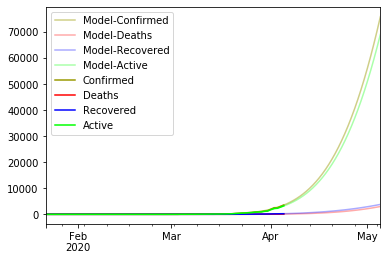

In [10]:
import datetime
start_date = df.index[0]
n_days = len(df) + 30
extended_model_x = []
last_row = []

isValid = True
last_death_rate = 0

for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
    
    #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
    if (t > len(df)):
        last_row = extended_model_x[-1]
        if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.12):
            if (isValid):
                last_row2 = extended_model_x[-2]
                last_death_rate = last_row2[2]/last_row2[1]
                isValid = False

        if (last_row[2] > last_row[1]*0.05):
            last_row[2] = last_row[1]*last_death_rate
            
        if (last_row[2] + last_row[3] > last_row[1]):
            last_row[2] = last_row[1]*last_death_rate
            last_row[3] = last_row[1]*(1-last_death_rate)

extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)

extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']
extended_model_sim['Model-Active'] = extended_model_sim['Model-Confirmed'] - extended_model_sim['Model-Deaths'] - extended_model_sim['Model-Recovered']
extended_model_sim.loc[extended_model_sim['Model-Active']<0,'Model-Active'] = 0

plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([extended_model_sim, df], axis=1).plot(color = plot_color)
print('India COVID-19 Prediction')
plt.show()



In [11]:
df.tail()

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-04-01,1998,58,148,1792
2020-04-02,2543,72,191,2280
2020-04-03,2567,72,192,2303
2020-04-04,3082,86,229,2767
2020-04-05,3588,99,229,3260


In [12]:
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 3 == 0]

,Confirmed,Deaths,Recovered,Active,Model-Confirmed,Model-Deaths,Model-Recovered,Model-Active
2020-01-24,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0
2020-01-30,1,0,0,1,0,0,0,0
2020-02-03,3,0,0,3,0,0,0,0
2020-02-06,3,0,0,3,0,0,0,0
2020-02-09,3,0,0,3,0,0,0,0
2020-02-12,3,0,0,3,0,0,0,0
2020-02-15,3,0,0,3,0,0,0,0
2020-02-18,3,0,3,0,0,0,0,0
2020-02-21,3,0,3,0,0,0,0,0


In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time

In [14]:
submission_example = pd.read_csv("F:\SAROJ WORLD\PROJECTS\p1/submission.csv")
test = pd.read_csv("F:\SAROJ WORLD\PROJECTS\p1/test.csv")
train = pd.read_csv("F:\SAROJ WORLD\PROJECTS\p1/train.csv")
display(train.head(5))
display(train.describe())
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train[train['Province_State'].isna()==False]['Country_Region'].unique())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0,0
1,2,NaN,Afghanistan,2020-01-23,0,0
2,3,NaN,Afghanistan,2020-01-24,0,0
3,4,NaN,Afghanistan,2020-01-25,0,0
4,5,NaN,Afghanistan,2020-01-26,0,0


,Id,ConfirmedCases,Fatalities
count,"19,110","19,110","19,110"
mean,"14,683",366,14
std,"8,487","3,696",196
min,1,0,0
25%,"7,333",0,0
50%,"14,683",0,0
75%,"22,033",17,0
max,"29,365","80,589","8,215"


Number of Country_Region:  173
Dates go from day 2020-03-26 to day 2020-01-22 , a total of 65 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


Text(0.5, 0, 'Date')

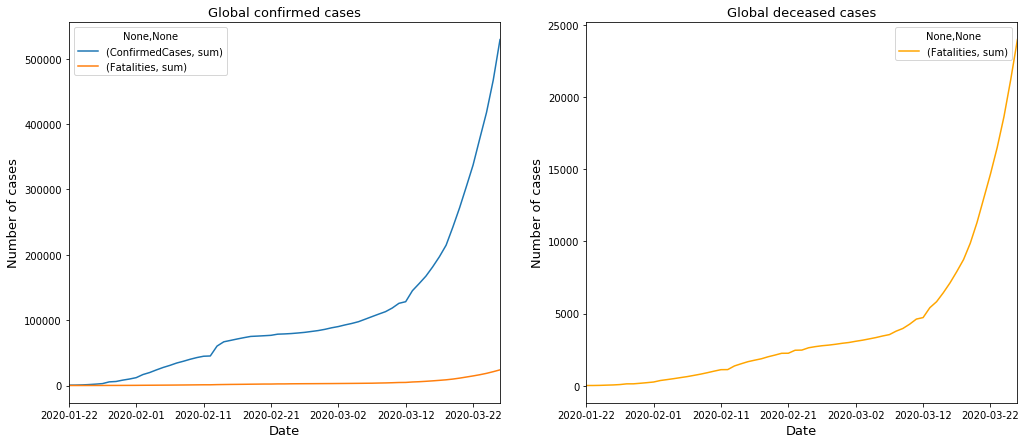

In [15]:
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

Text(0, 0.5, 'Confirmed infection cases')

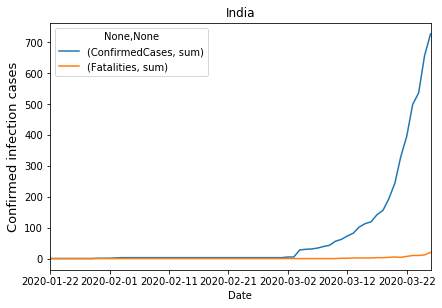

In [16]:
confirmed_total_date_India = train[train['Country_Region']=='India'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_India = train[train['Country_Region']=='India'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_India = confirmed_total_date_India.join(fatalities_total_date_India)
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_India.plot(ax=plt.gca(), title='India')
plt.ylabel("Confirmed infection cases", size=13)

In [17]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [18]:
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [19]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

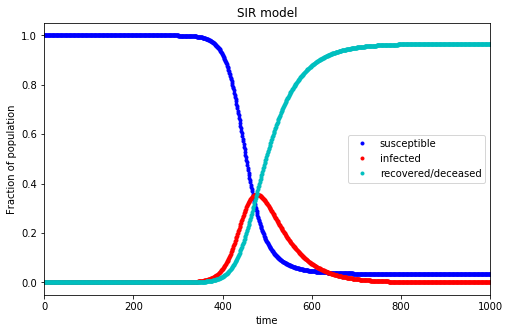

In [20]:
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

C:\Users\HP WORLD\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


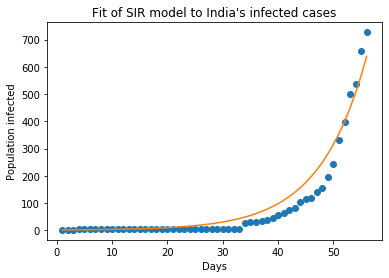

Optimal parameters: beta = -0.050120788526955506  and gamma =  -0.16755325831179055


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
pop_india=1380004385
population = float(pop_india)
country_df = total_date_India[9:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases['sum'].values]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model to India's infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [22]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-03-19', 'ConfirmedCases'] = np.nan
all_data.loc[all_data['Date'] >= '2020-03-19', 'Fatalities'] = np.nan
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-03-19'])

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1,None,Afghanistan,2020-01-22,0,0,-1,0,22,1,2020
1,2,None,Afghanistan,2020-01-23,0,0,-1,1,23,1,2020
2,3,None,Afghanistan,2020-01-24,0,0,-1,2,24,1,2020
3,4,None,Afghanistan,2020-01-25,0,0,-1,3,25,1,2020
4,5,None,Afghanistan,2020-01-26,0,0,-1,4,26,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
12637,-1,None,Zimbabwe,2020-04-26,0,0,"12,638",95,26,4,2020
12638,-1,None,Zimbabwe,2020-04-27,0,0,"12,639",96,27,4,2020
12639,-1,None,Zimbabwe,2020-04-28,0,0,"12,640",97,28,4,2020
12640,-1,None,Zimbabwe,2020-04-29,0,0,"12,641",98,29,4,2020


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,-1,None,Afghanistan,2020-03-19,0,0,1,57,19,3,2020
43,-1,None,Albania,2020-03-19,0,0,44,57,19,3,2020
86,-1,None,Algeria,2020-03-19,0,0,87,57,19,3,2020
129,-1,None,Andorra,2020-03-19,0,0,130,57,19,3,2020
172,-1,None,Angola,2020-03-19,0,0,173,57,19,3,2020
...,...,...,...,...,...,...,...,...,...,...,...
12427,-1,None,Uzbekistan,2020-03-19,0,0,"12,428",57,19,3,2020
12470,-1,None,Venezuela,2020-03-19,0,0,"12,471",57,19,3,2020
12513,-1,None,Vietnam,2020-03-19,0,0,"12,514",57,19,3,2020
12556,-1,None,Zambia,2020-03-19,0,0,"12,557",57,19,3,2020


In [23]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province_State  0
Country_Region  0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0
Day             0
Month           0
Year            0


In [24]:
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)
    return df


def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df
ts = time.time()
all_data = calculate_lag(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.2517733573913574
